# 4. Evaluation Metrics for Classification

When we trained a classification model, how do we know if it's good?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8026969481902059

## 4.2 Accuracy and dummy model

In [8]:
from sklearn.metrics import accuracy_score

In [9]:
#use sklearn library to compute accuracy score
accuracy_score(y_val,y_pred > 0.5)

0.8026969481902059

In [10]:
# try to use difference threshold to check the accurary score
thresholds = np.linspace(0,1,21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >=t)
    print('%.2f %.3f' % (t,score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.592
0.15 0.666
0.20 0.710
0.25 0.738
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


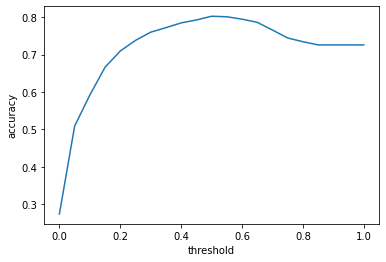

In [11]:
plt.plot(thresholds, scores)
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.show()

In [12]:
from collections import Counter

In [13]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [14]:
# accuracy if we force all the prediction is not churn (0)
1 - y_val.mean()

0.7260468417317246

In [15]:
# Show imbalanced dataset : Churn vs Non Churn => 1023 : 386 
Counter(y_val == 1)

Counter({False: 1023, True: 386})

## 4.3 Confusion table

In [16]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [17]:
t = 0.5
predict_positive = (y_pred >= 0.5)
predict_negative = (y_pred < 0.5)

In [18]:
tp = (actual_positive & predict_positive).sum()
tn = (actual_negative & predict_negative).sum()

In [19]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [20]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[921, 102],
       [176, 210]])

In [21]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

In [22]:
len(y_val)

1409

## 4.4 Precision and Recall

In [23]:
(tp + tn) / (tp + tn + fp + fn)

0.8026969481902059

In [24]:
precision = tp / (fp + tp)
precision

0.6730769230769231

In [25]:
recall = tp / (fn + tp)
recall

0.5440414507772021

## 4.5 ROC Curves

### TPR and FRP (our trained model)

In [26]:
#true positive rate
tpr = tp / (tp+fn)
tpr

0.5440414507772021

In [27]:
#false postive rate
fpr = fp / (fp+tn)
fpr

0.09970674486803519

In [28]:
scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t,tp,fp,fn,tn))

In [29]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

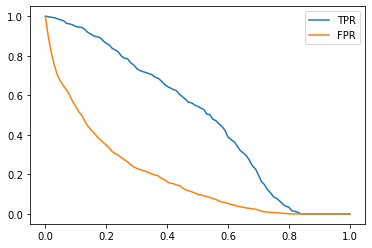

In [30]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [31]:
np.random.seed(1)
#build random model with randomly generate score
y_rand = np.random.uniform(0,1,size=len(y_val))

In [32]:
#get accuracy of random model
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [33]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [34]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

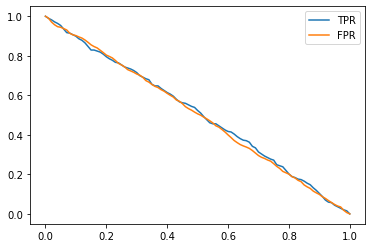

In [35]:
plt.plot(df_rand.threshold, df_rand['tpr'], label="TPR")
plt.plot(df_rand.threshold, df_rand['fpr'], label="FPR")
plt.legend()

### Ideal Model

In [36]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [37]:
#create dummy y data that have ideal separation between the no_churn and churn customer
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [38]:
#get y_val mean to know proportion of no churn customer (1 - portion of churn customer)
1 - y_val.mean()

0.7260468417317246

In [39]:
#ideal predition with ideal y data should produce 100% accuracy
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [40]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


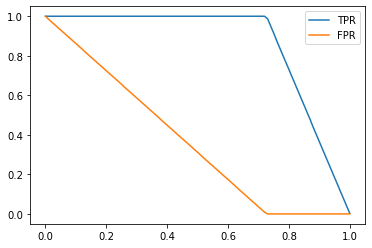

In [41]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

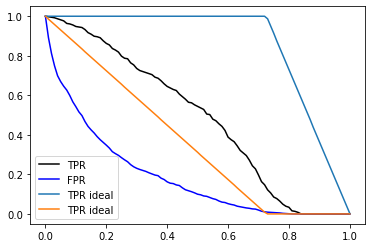

In [42]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_scores.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_scores.threshold, df_ideal['fpr'], label='TPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

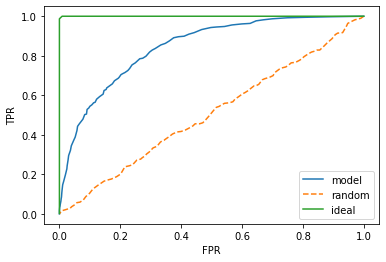

In [43]:
plt.plot(df_scores['fpr'] ,df_scores['tpr'], label='model')
plt.plot(df_rand['fpr'], df_rand['tpr'], label='random',linestyle='--')
plt.plot(df_ideal['fpr'], df_ideal['tpr'], label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [44]:
from sklearn.metrics import roc_curve

In [45]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

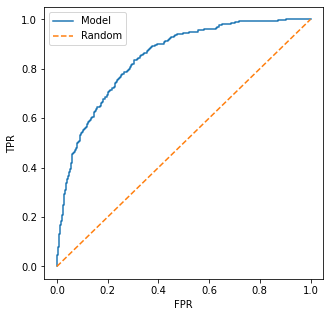

In [46]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### 4.6 ROC AUC

* Area under the ROC curve - useful metric
* interpretation of AUC

In [47]:
from sklearn.metrics import auc


In [48]:
#auc of our trained model 
# auc calculate area under the curve
auc(fpr, tpr)

0.8438429084426077

In [49]:
#the ideal model auc is 1
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [50]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438429084426077

In [51]:
#shortcut library to calculate roc and auc at once from sklearn
from sklearn.metrics import roc_auc_score

In [52]:
roc_auc_score(y_val, y_pred)

0.8438429084426077

In [53]:
#get group data for each positive and negative example
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [54]:
import random

In [55]:
# AUC can be interpreted as the probability that a randomly selected positive example has a greater score than a randomly selected negative example.
n = 100000
success = 0 

for i in range(n):
    #get randomly index from  postive examples and negative examples
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    #check if retrieved positive value is higher from the negative one
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84413

In [56]:
#using numpy approach
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84654

## 4.7 Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [57]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [58]:
dv, model = train(df_train, y_train, C=0.001)

In [60]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [61]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.02155921, 0.33135098, 0.33602112, ..., 0.26705435, 0.71907523,
       0.71942517])

In [62]:
from sklearn.model_selection import KFold

In [63]:
!pip install tqdm

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [64]:
from tqdm.auto import tqdm

In [65]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        #get training and validation data based on k-fold indexes
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        #get target(y) values for train and val dataset
        y_train = df_train.churn.values
        y_val = df_val.churn.values

        #train modelwith splitted dataset and then predict
        #use parameter based on "C" variable (here we check various "C" parameter values)
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        #calculate auc and append it to scores list
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.007
C=1 0.841 +- 0.008
C=5 0.841 +- 0.008
C=10 0.841 +- 0.007



In [91]:
# train model with combine train and val dataset as full train dataset
# use default C="1.0" since there is no significant diff with other C values
# test the model using test dataset
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

# calculate auc score
auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259